In [242]:
# def accuracy_metric(y_true, y_pred):
#   # appropriate for balanced classes
#   correct_preds = torch.eq(y_true, y_pred).sum().item()
#   return (correct_preds / len(y_pred)) * 100

In [243]:
import numpy as np
import torch
import matplotlib.pyplot as plt

def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
  model.to("cpu")
  X, y = X.to("cpu"), y.to("cpu")

  x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
  y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
  xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

  X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

  model.eval()
  with torch.inference_mode():
      y_logits = model(X_to_pred_on)

  if len(torch.unique(y)) > 2:
      y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
  else:
      y_pred = torch.round(torch.sigmoid(y_logits))          # binary

  y_pred = y_pred.reshape(xx.shape).detach().numpy()
  plt.contourf(xx, yy, y_pred, alpha=0.25, cmap=plt.cm.viridis)
  plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.viridis)
  plt.xlim(xx.min(), xx.max())
  plt.xlabel('Feature 1')
  plt.ylim(yy.min(), yy.max())
  plt.ylabel('Feature 2')

# **1. Multi-Class Classification Problems**

- Recall a **binary classification** problem deals with classifying in **one of two options** (e.g.; a photo: a cat, or a dog; email: spam or not spam).
- A **multi-class classification** problem deals with classifying in **one of more than two options**.
  - Classifying a photo: cat, dog, or chicken;
  - Email: spam, primary, promotion, social, updates, forums.

## **1.1. Get Data and Prepare**

- To begin a multi-class classification problem, let us create some multi-class data:

    - Create some multi-class data with [`make_blobs()`](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html) method from Scikit-Learn's Library.
    - Visualize the data.
    - Turn the data into tensors.
    - Split the data into train and test sets.


### **1.1.1. Data**

In [244]:
import torch
from torch import nn
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs, make_moons
from sklearn.model_selection import train_test_split

- In the code below, `cluster_std` is the standard deviation of the observations within a class.
- The default is 1, set it to 0 and observe the difference.

In [245]:
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

X_array, y_array = X, y =  make_blobs(n_samples = 1000, n_features = NUM_FEATURES,
                                      centers = NUM_CLASSES, cluster_std = 2,
                                      random_state = RANDOM_SEED)

In [246]:
num_classes = len(np.unique(y_array))
num_classes

4

-  Visualize the data

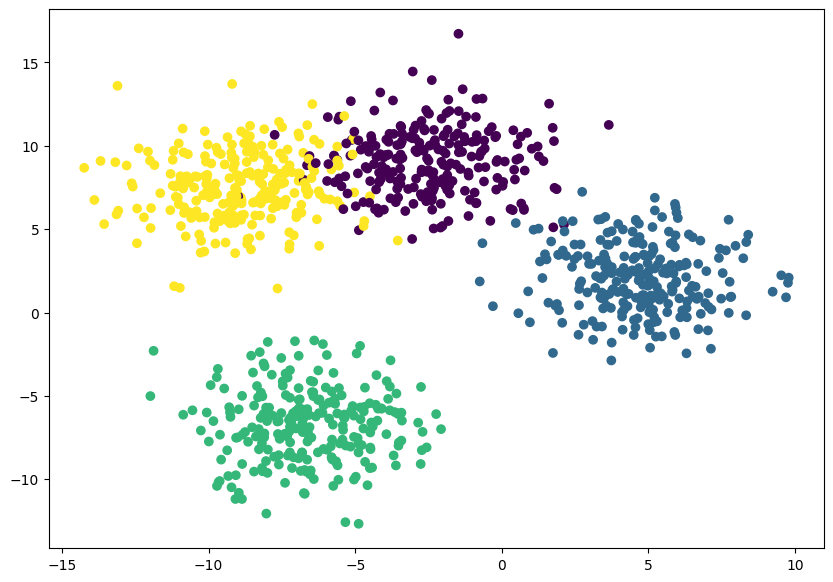

In [247]:
plt.figure(figsize = (10, 7))
plt.scatter(X_array[ : , 0], X_array[ : , 1], c = y_array, cmap=plt.cm.viridis);

- Does this dataset need non-linearity?
- Could we draw a succession of straight lines to separate it?

### **1.1.2. Train and test splits**

In [248]:
np.random.seed(42)
X_train_array, X_test_array, y_train_array, y_test_array = train_test_split(X_array, y_array, test_size=0.2, random_state=RANDOM_SEED)

### **1.1.3. Turn to tensors**.

- We have been specifying the data types to be float.


In [249]:
X_train = torch.from_numpy(X_train_array).type(torch.float)
X_test = torch.from_numpy(X_test_array).type(torch.float)
print(X_train.type(), X_test.type())
X_train[:5], X_test[:5]

torch.FloatTensor torch.FloatTensor


(tensor([[ 5.1740,  3.7524],
         [-2.6634,  9.6966],
         [-9.0722, -9.7602],
         [-5.7417, -3.6233],
         [-3.6165,  6.6185]]),
 tensor([[ 4.6767,  5.3260],
         [-7.7165,  6.7326],
         [-6.0803, -8.1828],
         [ 3.3644,  0.9112],
         [ 0.6492, 10.5492]]))

- **Note**:
    - The target data type in the multi-class problem should be **long, not float**.
    - In [cross entropy loss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) documentation, there is a note about '**target** to contain **class indices**' for optimized computation.
    - And in the examples, it has been used as: `target = torch.empty(3, dtype=torch.long).random_(5)`.
- If it is float, the loss calculation will raise an error during training.

In [250]:
y_train = torch.tensor(y_train_array, dtype=torch.long)
y_test = torch.tensor(y_test_array, dtype=torch.long)
print(y_train[:5], y_test[:5])
y_train.type(), y_test.type()

tensor([1, 0, 2, 2, 0]) tensor([1, 3, 2, 1, 0])


('torch.LongTensor', 'torch.LongTensor')

## **1.2. Build Model**



### **1.2.1. Define and Instantiate It**
- How can we build a model capable of handling multi-class data?

- Let us create a subclass of `nn.Module` that takes:
    * `input_features` - number of `X` features.
    * `output_features` - numbers of output `y` features (equivalent to `NUM_CLASSES`).
    * `hidden_units` - number of hidden neurons in each hidden layer.

In [251]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

-**TBC again**: I better consider other simulated data that reflects the inclusion and exclusion of layers have an effect on the model to be trained. The current data does not show any differences when the layers are commented or included.

In [252]:
from torch import nn

class MultiClassModelV1(nn.Module):
    def __init__(self, input_features, output_features, hidden_units = 8):
        super().__init__()
        self.fc_layers = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_features)
        )

    def forward(self, x):
        return self.fc_layers(x)

- Create an instance of the model and send it to the target device

In [253]:
num_features = X_train.shape[1]
num_classes = len(y_train.unique())

mc_model_1 = MultiClassModelV1(input_features = num_features,
                             output_features = num_classes,
                             hidden_units = 8).to(device)
mc_model_1

MultiClassModelV1(
  (fc_layers): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [254]:
next(mc_model_1.parameters()).device, X_train.device

(device(type='cuda', index=0), device(type='cpu'))

In [255]:
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)
X_train.device, X_test.device, y_train.device, y_test.device

(device(type='cuda', index=0),
 device(type='cuda', index=0),
 device(type='cuda', index=0),
 device(type='cuda', index=0))

### **1.2.2. Forward Pass Outputs**

- The multi-class model is now ready to perform a single forward pass on the data.

In [256]:
with torch.inference_mode():
  y_preds = mc_model_1(X_test.to(device))

print(y_preds[:5])

tensor([[ 0.7502, -0.5664,  0.3349, -0.2461],
        [-0.3162, -1.7475, -0.3072, -1.1094],
        [ 0.1551, -0.8605,  0.3147, -0.9017],
        [ 0.4327, -0.4324,  0.2350, -0.1933],
        [ 0.9230, -0.9330,  0.3317, -0.5008]], device='cuda:0')


- How many elements in a single prediction example?

In [257]:
y_preds.shape, num_classes

(torch.Size([200, 4]), 4)

- The model is predicting one value for each class.
- Remember the **raw outputs of the binary classification model** are called **logits**.
- Here, the model can also be considered as outputing logits for each class.
- How can determine **to which class each example belongs**?
- Go from **predicted logits -> predicted probabilities -> predicted classes** as did with binary classification problem.
- The [softmax activation function](https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html) comes into play.
    - It converts the predicted logits into a discrete probability distribution.

In [258]:
y_pred_probs = torch.softmax(y_preds, dim=1)

print(y_pred_probs[:5])

tensor([[0.4353, 0.1167, 0.2873, 0.1607],
        [0.3703, 0.0885, 0.3737, 0.1675],
        [0.3469, 0.1256, 0.4069, 0.1206],
        [0.3602, 0.1516, 0.2956, 0.1926],
        [0.5126, 0.0801, 0.2838, 0.1234]], device='cuda:0')


- After passing the logits through the softmax function, each individual example now adds (very close) to 1.

In [259]:
torch.sum(y_pred_probs[0])

tensor(1.0000, device='cuda:0')

- The class with the **the highest probability** is the class the specific data example **most belongs to**.
- We can identify the index with the highest probability using [`torch.argmax()`](https://pytorch.org/docs/stable/generated/torch.argmax.html).

In [260]:
print(y_pred_probs[0])
print(torch.argmax(y_pred_probs[0]))

tensor([0.4353, 0.1167, 0.2873, 0.1607], device='cuda:0')
tensor(0, device='cuda:0')


- For the multiclass classifiction problem, the [`torch.argmax()`](https://pytorch.org/docs/stable/generated/torch.argmax.html)calculation is used across dimension 1.

In [261]:
y_pred_class = torch.argmax(y_pred_probs, dim=1)
y_pred_class

tensor([0, 2, 2, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 2,
        2, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 2, 2, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 2, 2, 0, 2, 2, 2, 0, 0, 0, 2, 0, 0, 0,
        2, 0, 2, 2, 2, 0, 0, 0, 0, 2, 0, 2, 2, 2, 2, 2, 2, 2, 0, 2, 0, 2, 2, 2,
        0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2,
        2, 2, 0, 0, 2, 0, 0, 0, 2, 2, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2,
        2, 2, 0, 0, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0, 2, 0, 2, 0, 2, 2, 0, 2, 2, 0,
        0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 0, 2, 2, 0, 0, 2, 2, 0, 0,
        0, 2, 2, 0, 2, 0, 2, 0], device='cuda:0')

- Of course, right now the predictions are just random guessing.

In [262]:
y_test

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0, 0, 1, 0, 0, 0, 3, 3, 2, 3, 3, 3, 0, 1, 2,
        2, 2, 3, 0, 1, 0, 3, 1, 1, 3, 1, 2, 1, 3, 0, 2, 0, 3, 3, 2, 0, 3, 1, 1,
        0, 3, 1, 0, 1, 1, 3, 2, 1, 1, 3, 2, 2, 0, 3, 2, 2, 0, 0, 3, 3, 0, 0, 3,
        3, 3, 2, 3, 3, 3, 3, 1, 0, 2, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 1, 3, 3, 3,
        1, 0, 3, 2, 0, 0, 3, 0, 2, 3, 1, 0, 3, 2, 1, 1, 0, 2, 2, 3, 0, 0, 1, 2,
        2, 3, 0, 1, 2, 0, 0, 0, 2, 3, 1, 2, 3, 2, 0, 3, 0, 0, 1, 1, 1, 0, 2, 2,
        2, 2, 0, 3, 3, 2, 2, 1, 3, 2, 0, 0, 3, 3, 2, 1, 2, 0, 3, 2, 0, 3, 2, 0,
        2, 2, 2, 0, 3, 1, 1, 1, 1, 1, 3, 1, 0, 2, 2, 1, 2, 2, 0, 1, 2, 2, 0, 0,
        1, 3, 2, 0, 3, 1, 2, 1], device='cuda:0')

In [263]:
sum(y_pred_class==y_test)/len(y_test)

tensor(0.4850, device='cuda:0')

- **Note:**
    - It is possible go straight from **predicted logits -> predicted labels** by calling `torch.argmax()`  directly on the logits (**y_preds = torch.argmax(y_logits, dim=1)**), skipping the `torch.softmax()` function.
    - It saves **saves a computation step** (no `torch.softmax()`).
    - However, the exponentiation of the logits in the softmax function can help for **numerical stability**, especially when dealing with large or small values.
    - As a result, softmax helps in **stabilizing the computation** and **maintaining a valid probability distribution**.

### **1.2.3. Training and Testing**

- For a multi-class classification problem, the [`nn.CrossEntropyLoss()`](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) method is used as a **loss** function.
- Let us train the model for `epochs=100` and evaluate it every 10 epochs.

In [264]:
from sklearn.metrics import accuracy_score

In [265]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

mc_model1 = MultiClassModelV1(input_features = NUM_FEATURES,
                           output_features = NUM_CLASSES,
                           hidden_units = 8).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(mc_model1.parameters(), lr = 0.1)

epochs = 100

for epoch in range(1, epochs + 1):
  y_pred_logits = mc_model1(X_train)
  y_pred_labels = torch.softmax(y_pred_logits, dim=1).argmax(dim=1)

  loss = criterion(y_pred_logits, y_train)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  accuracy = accuracy_score(y_true=y_train.cpu(),
                            y_pred=y_pred_labels.cpu()) * 100

  mc_model1.eval()
  with torch.inference_mode():
    test_pred_logits = mc_model1(X_test)
    test_pred_labels = torch.softmax(test_pred_logits, dim=1).argmax(dim=1)
    test_loss = criterion(test_pred_logits, y_test)
    test_accuracy = accuracy_score(y_true = y_test.cpu(),
                                   y_pred = test_pred_labels.cpu()) * 100

  if epoch % 10 == 0:
      print(f"Epoch: {epoch}, ", end='')
      print(f"Loss (train, test): ({loss:.5f}, {test_loss:.5f}); ", end='')
      print(f"Accuracy (train, test): ({accuracy:.2f}%, {test_accuracy:.2f}%).")

Epoch: 10, Loss (train, test): (0.70575, 0.71796); Accuracy (train, test): (91.75%, 91.50%).
Epoch: 20, Loss (train, test): (0.49626, 0.50276); Accuracy (train, test): (94.50%, 95.50%).
Epoch: 30, Loss (train, test): (0.33689, 0.33028); Accuracy (train, test): (95.88%, 97.00%).
Epoch: 40, Loss (train, test): (0.19288, 0.17883); Accuracy (train, test): (96.12%, 96.50%).
Epoch: 50, Loss (train, test): (0.13438, 0.12215); Accuracy (train, test): (96.25%, 96.50%).
Epoch: 60, Loss (train, test): (0.11612, 0.10363); Accuracy (train, test): (96.25%, 96.50%).
Epoch: 70, Loss (train, test): (0.10792, 0.09516); Accuracy (train, test): (96.12%, 96.50%).
Epoch: 80, Loss (train, test): (0.10336, 0.09045); Accuracy (train, test): (96.12%, 96.50%).
Epoch: 90, Loss (train, test): (0.10046, 0.08753); Accuracy (train, test): (96.12%, 96.50%).
Epoch: 100, Loss (train, test): (0.09843, 0.08555); Accuracy (train, test): (96.12%, 96.50%).


It looks like the trained model is performaning pretty well.

### **1.2.4. Model Evaluation**



- Let us view the predictions

In [266]:
with torch.inference_mode():
    y_pred_logits = mc_model1(X_test)

y_pred_logits[:10]

tensor([[  0.0115,   6.0601,  -8.4093,  -8.4163],
        [ -1.4769,  -6.0067,  -4.1702,   2.5993],
        [ -3.3982,  -3.7515,   3.1081,  -2.6314],
        [ -1.0987,   4.1476,  -3.5406,  -4.2915],
        [  3.7035,  -1.0898, -10.0379,  -6.3261],
        [ -2.0053,  -7.4626,  -5.2498,   3.4261],
        [ -2.9233,  -3.0336,   2.7233,  -2.0891],
        [  2.8830,  -4.4700,  -7.1183,  -2.5822],
        [ -4.5562,  -5.1398,   3.8900,  -3.6046],
        [  3.3123,  -3.2114,  -7.8873,  -3.7766]], device='cuda:0')

- Convert model's prediction logits to prediction probabilities.

In [267]:
y_pred_probs = torch.softmax(y_pred_logits, dim=1)
y_pred_probs[:10]

tensor([[2.3556e-03, 9.9764e-01, 5.1879e-07, 5.1516e-07],
        [1.6666e-02, 1.7971e-04, 1.1276e-03, 9.8203e-01],
        [1.4854e-03, 1.0433e-03, 9.9427e-01, 3.1980e-03],
        [5.2357e-03, 9.9409e-01, 4.5550e-04, 2.1496e-04],
        [9.9174e-01, 8.2164e-03, 1.0680e-06, 4.3712e-05],
        [4.3570e-03, 1.8583e-05, 1.6986e-04, 9.9545e-01],
        [3.4778e-03, 3.1147e-03, 9.8540e-01, 8.0098e-03],
        [9.9511e-01, 6.3754e-04, 4.5122e-05, 4.2110e-03],
        [2.1453e-04, 1.1968e-04, 9.9911e-01, 5.5558e-04],
        [9.9769e-01, 1.4649e-03, 1.3647e-05, 8.3236e-04]], device='cuda:0')

- Convert prediction probabilities to prediction labels.

In [268]:
y_pred_labels = y_pred_probs.argmax(dim=1)
y_pred_labels[:10]

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')

- Compare first 10 model preds and test labels.

In [269]:
print(f"Predictions: {y_pred_labels[:10]}\nLabels: {y_test[:10]}")
print(f"Test accuracy: {accuracy_score(y_true=y_test.cpu(), y_pred=y_pred_labels.cpu())}%")

Predictions: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')
Labels: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')
Test accuracy: 0.965%


- Let us visualize the class labels together with the decision boundaries with `plot_decision_boundary()`.
- Remember if data is on the GPU, it has to be moved to CPU for use with the plot of `matplotlib`.

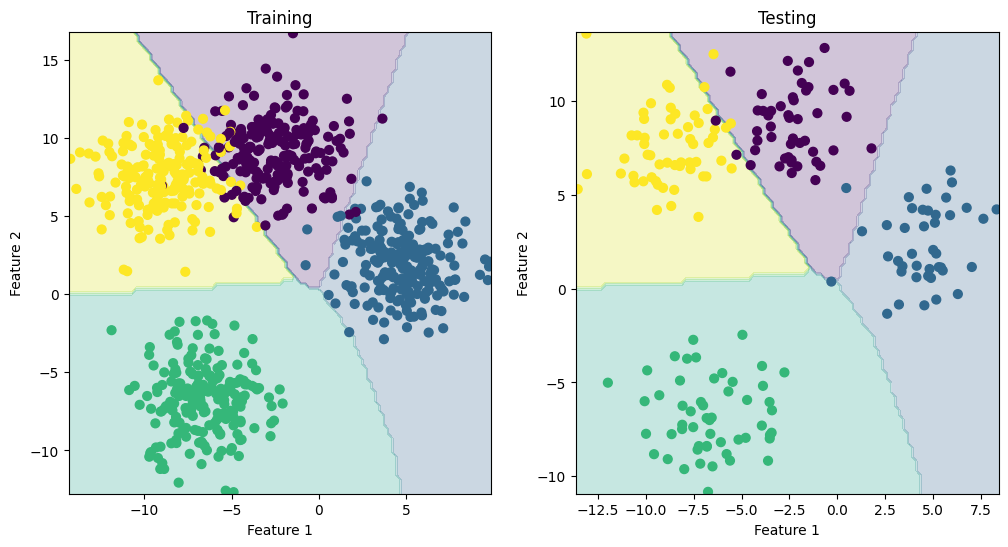

In [270]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)

plt.title("Training")
plot_decision_boundary(mc_model1, X_train, y_train)

plt.subplot(1, 2, 2)
plt.title("Testing")
plot_decision_boundary(mc_model1, X_test, y_test)

- If you re-run the model, commenting the ReLU activation functions, it still works, and the lines become more straight.
- This indicates that the data is **linearly separabl**e which is **not common in real world applications**.

**More Classification Evaluation Metrics**

- Like **classification metrics in the Scikit-Learn**, let us look for a PyTorch-like version called [torchmetrics](https://torchmetrics.readthedocs.io/en/latest/).
- However, the `torchmetrics` are not included as a basic component of PyTorch yet.

    - Accuracy: [`torchmetrics.Accuracy()`](https://torchmetrics.readthedocs.io/en/stable/classification/accuracy.html#id3)
    - Precision: [`torchmetrics.Precision()`](https://torchmetrics.readthedocs.io/en/stable/classification/precision.html#id4)
    - Recall: [`torchmetrics.Recall()`](https://torchmetrics.readthedocs.io/en/stable/classification/recall.html#id5)
    - F1-score: [`torchmetrics.F1Score()`](https://torchmetrics.readthedocs.io/en/stable/classification/f1_score.html#f1score)
    - [Confusion matrix](https://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/): [`torchmetrics.ConfusionMatrix`](https://torchmetrics.readthedocs.io/en/stable/classification/confusion_matrix.html#confusionmatrix)
    - Classification report: [`sklearn.metrics.classification_report()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html)







In [166]:
# try:
#     from torchmetrics import Accuracy
# except:
#     !pip install torchmetrics
#     from torchmetrics import Accuracy

- Calculate accuracy

In [ ]:
# torchmetrics_accuracy = Accuracy(task='multiclass', num_classes=4).to(device)
# torchmetrics_accuracy.device
# torchmetrics_accuracy(y_pred_labels, y_test)

tensor(0.9950)

# **2. Multi-Label Classification**

## **2.1. Get Data**

In [49]:
import numpy as np
from sklearn.datasets import make_multilabel_classification
import matplotlib.pyplot as plt

np.random.seed(42)
torch.manual_seed(42)

NUM_SAMPLES = 1000
NUM_FEATURES = 2
NUM_CLASSES = 4

X, Y = make_multilabel_classification(n_samples=NUM_SAMPLES,
                                      n_features=NUM_FEATURES,
                                      n_classes=NUM_CLASSES,
                                      random_state=42)

In [29]:
X

array([[26., 23.],
       [21., 26.],
       [40.,  8.],
       ...,
       [18., 46.],
       [19., 28.],
       [26., 29.]])

In [30]:
Y

array([[0, 1, 1, 0],
       [1, 0, 1, 1],
       [0, 0, 1, 0],
       ...,
       [1, 0, 0, 0],
       [0, 1, 1, 1],
       [0, 0, 0, 1]])

In [41]:
num_features = X.shape[1]
num_outputs = Y.shape[1]
num_features, num_outputs

(2, 4)

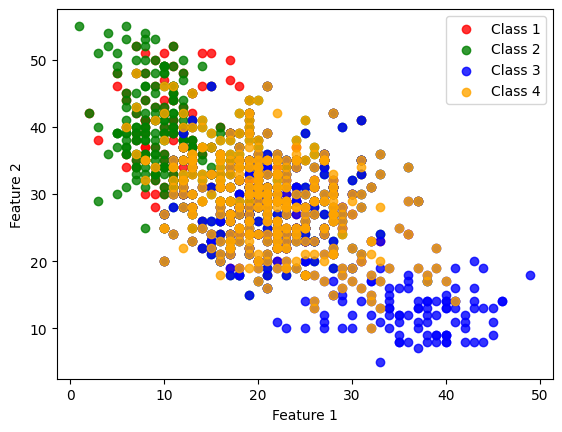

In [50]:
colors = ['red', 'green', 'blue', 'orange']
for i in range(NUM_CLASSES):
    plt.scatter(X[Y[:, i] == 1][:, 0], X[Y[:, i] == 1][:, 1], color=colors[i], label=f'Class {i+1}', alpha=0.8)

plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.show();

In [51]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import torch

X = torch.from_numpy(X).type(torch.float)
Y = torch.from_numpy(Y).type(torch.float)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [52]:
import torch
import torch.nn as nn
import torch.optim as optim

class MultiLabelNN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(MultiLabelNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 8)
        self.fc2 = nn.Linear(8, 16)
        self.fc3 = nn.Linear(16, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return self.sigmoid(x)

In [53]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [55]:
X_train, X_test = X_train.to(device), X_test.to(device)
Y_train, Y_test = Y_train.to(device), Y_test.to(device)

model = MultiLabelNN(input_dim=num_features, output_dim=num_outputs).to(device)

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 100
for epoch in range(num_epochs):
  model.train()
  Y_preds = model(X)
  loss = criterion(Y_preds, Y)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model.eval()
  with torch.inference_mode():
    Y_preds = model(X_test)
    Y_pred_labels = (Y_preds > 0.5).float()

    f1 = f1_score(Y_test.numpy(), Y_pred_labels.numpy(), average='micro')
  if num_epochs % (epoch + 1) == 0:
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, F1 Score: {f1:.4f}')

Epoch [1/100], Loss: 0.7556, F1 Score: 0.1265
Epoch [2/100], Loss: 0.7496, F1 Score: 0.1530
Epoch [4/100], Loss: 0.7385, F1 Score: 0.1673
Epoch [5/100], Loss: 0.7333, F1 Score: 0.1688
Epoch [10/100], Loss: 0.7104, F1 Score: 0.1855
Epoch [20/100], Loss: 0.6774, F1 Score: 0.2998
Epoch [25/100], Loss: 0.6652, F1 Score: 0.3699
Epoch [50/100], Loss: 0.6206, F1 Score: 0.5331
Epoch [100/100], Loss: 0.5674, F1 Score: 0.5420


In [56]:
with torch.inference_mode():
    Y_preds = model(X_test)
    Y_pred_labels = (Y_preds > 0.5).float()

    f1 = f1_score(Y_test.numpy(), Y_pred_labels.numpy(), average='micro')
    print(f'F1 Score: {f1:.4f}')


F1 Score: 0.5420


In [57]:
Y_preds

tensor([[0.4664, 0.6300, 0.3862, 0.4757],
        [0.0744, 0.2759, 0.7064, 0.3116],
        [0.5682, 0.6672, 0.3697, 0.4985],
        [0.4129, 0.6002, 0.4172, 0.4714],
        [0.5850, 0.6955, 0.3136, 0.4821],
        [0.4609, 0.6344, 0.3721, 0.4690],
        [0.1343, 0.3618, 0.6341, 0.3854],
        [0.2588, 0.4707, 0.5706, 0.4566],
        [0.4502, 0.6248, 0.3868, 0.4713],
        [0.6153, 0.7363, 0.2379, 0.4519],
        [0.5962, 0.7083, 0.2903, 0.4735],
        [0.1413, 0.3674, 0.6331, 0.3892],
        [0.0206, 0.1572, 0.8077, 0.1773],
        [0.3816, 0.5894, 0.4183, 0.4626],
        [0.4029, 0.7563, 0.1252, 0.2319],
        [0.4022, 0.6091, 0.3884, 0.4581],
        [0.3816, 0.5894, 0.4183, 0.4626],
        [0.5747, 0.7029, 0.3024, 0.4585],
        [0.2493, 0.7655, 0.0690, 0.1196],
        [0.4621, 0.7240, 0.1994, 0.3192],
        [0.4182, 0.7315, 0.1666, 0.2717],
        [0.5318, 0.6505, 0.3840, 0.4934],
        [0.3613, 0.7540, 0.1138, 0.2029],
        [0.2634, 0.5156, 0.4863, 0

In [58]:
Y_pred_labels

tensor([[0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [1., 1., 0., 0.],
        [0., 1., 0., 0.],
        [1., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 1., 0., 0.],
        [1., 1., 0., 0.],
        [1., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [1., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [1., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [1., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 1., 0., 0.],
        [1., 1., 0., 0.],
        [0., 1., 0., 0.],
        [1., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 1., 0., 0.],
        [1., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0.,

## **Example** To be Included